# Cyber Bullying Detection
<div style="">
  <img src="https://media2.giphy.com/media/v1.Y2lkPTc5MGI3NjExaDR1aWJ3OWZhdXZ0MzdvNWx0NnZta3BvZTloY2lsNzBjaWc1MjFpbSZlcD12MV9pbnRlcm5hbF9naWZfYnlfaWQmY3Q9Zw/4z7Z1WeRCksA4MH8Om/giphy.gif" width="300">
</div>

In [ ]:
! pip install textattack

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 54.5/54.5 kB 2.1 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.6/3.6 MB 23.0 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 981.5/981.5 kB 35.2 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Preparing metadata (setup.py) ... done
  Preparing metadata (setup.py) ... done
  Preparing metadata (setup.py) ... done
  Preparing metadata (setup.py) ... done
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 61.0/61.0 kB 3.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 445.7/445.7 kB 9.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 61.1/61.1 kB 3.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 491.2/491.2 kB 20.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 4.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━

In [ ]:
import os
import re
import nltk
import spacy
import numpy as np
import pandas as pd
from tqdm import tqdm
from wordcloud import WordCloud
import seaborn as sns
import plotly.express as px
import matplotlib.pyplot as plt
import plotly.figure_factory as ff
from plotly.subplots import make_subplots
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from keras.models import Sequential
from keras.layers import Dense, Flatten
from keras.utils import pad_sequences
from keras.utils import to_categorical
from sklearn.preprocessing import OneHotEncoder
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_selection import SelectKBest, chi2
from scipy.sparse import hstack, csr_matrix
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.models import Sequential
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.layers import Dense, Flatten, Dropout, Embedding, GlobalMaxPooling1D, Conv1D, SimpleRNN, LSTM, GRU, Bidirectional
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.utils import to_categorical
from sklearn.preprocessing import StandardScaler

from textattack.augmentation import WordNetAugmenter

from sklearn.metrics import classification_report, f1_score

nltk.download('punkt_tab')
import warnings
warnings.filterwarnings('ignore')

nltk.download('punkt')
nltk.download('stopwords')

nlp = spacy.load("en_core_web_sm")

stop_words = set(stopwords.words('english'))
stop_words = [i for i in stop_words if i not in ['not','until','against','up', 'down', 'no', 'nor',"aren't", 'couldn', "couldn't", 'didn', "didn't", 'doesn', "doesn't", 'hadn',
                                                "hadn't", 'hasn', "hasn't", 'haven', "haven't", 'isn', "isn't", 'ma', 'mightn', "mightn't", 'mustn', "mustn't", 'needn', "needn't",
                                                 'shan', "shan't", 'shouldn', "shouldn't", 'wasn', "wasn't", 'weren', "weren't", 'won', "won't", 'wouldn', "wouldn't", "don't"]]

ValueError: numpy.dtype size changed, may indicate binary incompatibility. Expected 96 from C header, got 88 from PyObject

In [ ]:
df = pd.read_csv("/dataset.csv")
df=df.sample(frac=1)
df=df.head(10000)
df.head()

,Unnamed: 0,content,label
9536,9536,Ha I'm ok. Just hate flathunting. Don't we all?!,0
13318,13318,no way!!! how could we hate you!!!,0
8045,8045,notice they waited for me to leave before they...,0
18195,18195,the cancer my little brother had to never co...,0
17738,17738,Any time i think about doin that i forget im...,0


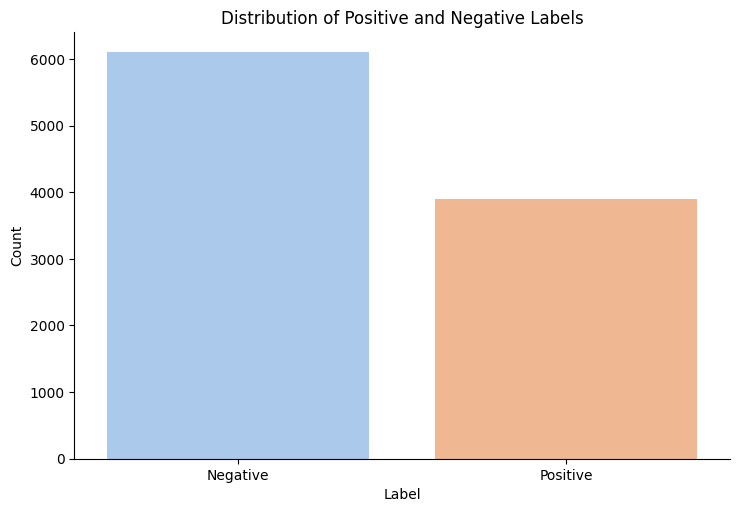

In [ ]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
df['label_name'] = df['label'].apply(lambda x: 'Positive' if x == 1 else 'Negative')
sns.catplot(x='label_name', kind='count', data=df, height=5, aspect=1.5, palette='pastel')
plt.title('Distribution of Positive and Negative Labels')
plt.xlabel('Label')
plt.ylabel('Count')

plt.show()

# FEATURE ENGINEERING

In [ ]:
def get_word_len(content):
    return len(content.split(' '))

def get_char_len(content):
    return len(content)

def preprocess_data(content):
    content = content.lower()
    content = re.sub(r"http\S+|www\S+|https\S+", '', content, flags=re.MULTILINE)  # Remove links
    content = re.sub(r'@\w+', '', content)  # Remove mentions
    content = re.sub(r'[^a-zA-Z\s]', '', content)  # Keep only letters and spaces
    tokens = [token.lemma_ for token in nlp(content) if token not in stop_words and len(token) > 1]
    return " ".join(tokens)

# Apply preprocessing
df["clean_content"] = df["content"].apply(preprocess_data)
df["content_word_len"] = df["clean_content"].apply(get_word_len)
df["content_char_len"] = df["clean_content"].apply(get_char_len)

# Normalization of numerical values
scaler = MinMaxScaler()
numerical_cols = ["content_word_len", "content_char_len"]
df[numerical_cols] = scaler.fit_transform(df[numerical_cols])

# Display processed data
df.head()

,Unnamed: 0,content,label,label_name,clean_content,content_word_len,content_char_len
9536,9536,Ha I'm ok. Just hate flathunting. Don't we all?!,0,Negative,ha ok just hate flathunting do not we all,0.043011,0.046119
13318,13318,no way!!! how could we hate you!!!,0,Negative,no way how could we hate you,0.032258,0.031496
8045,8045,notice they waited for me to leave before they...,0,Negative,notice they wait for I to leave before they ki...,0.086022,0.091114
18195,18195,the cancer my little brother had to never co...,0,Negative,the cancer my little brother have to never ...,0.064516,0.061867
17738,17738,Any time i think about doin that i forget im...,0,Negative,any time think about doin that forget count...,0.123656,0.112486


In [ ]:
# Convert text data into numerical features using TF-IDF vectorization
vectorizer = TfidfVectorizer(max_features=5000)
X_text = vectorizer.fit_transform(df["clean_content"])

# Define the target variable
y = df["label"]

# Use the Chi-Square test to select the top 1000 text features
chi2_selector = SelectKBest(chi2, k=1000)
X_text_selected = chi2_selector.fit_transform(X_text, y)
print(f"TF-IDF feature matrix shape: {X_text.shape} -> After selection: {X_text_selected.shape}")

# Convert normalized numerical features into a sparse matrix
X_numeric = df[numerical_cols].values
X_numeric_sparse = csr_matrix(X_numeric)
# Combine both feature sets horizontally
X_final = hstack([X_text_selected, X_numeric_sparse])

# Split the data into training and testing sets (80/20 split)
X_train, X_test, y_train, y_test = train_test_split(X_final, y, test_size=0.2, random_state=42)


TF-IDF feature matrix shape: (10000, 5000) -> After selection: (10000, 1000)


**MLP**

---



Epoch 1/10
125/125 ━━━━━━━━━━━━━━━━━━━━ 8s 18ms/step - accuracy: 0.6019 - loss: 0.6689 - val_accuracy: 0.7555 - val_loss: 0.5204
Epoch 2/10
125/125 ━━━━━━━━━━━━━━━━━━━━ 3s 6ms/step - accuracy: 0.7725 - loss: 0.5015 - val_accuracy: 0.7830 - val_loss: 0.4563
Epoch 3/10
125/125 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - accuracy: 0.8186 - loss: 0.4199 - val_accuracy: 0.7980 - val_loss: 0.4344
Epoch 4/10
125/125 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - accuracy: 0.8269 - loss: 0.3895 - val_accuracy: 0.7860 - val_loss: 0.4344
Epoch 5/10
125/125 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - accuracy: 0.8492 - loss: 0.3566 - val_accuracy: 0.8145 - val_loss: 0.4186
Epoch 6/10
125/125 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - accuracy: 0.8559 - loss: 0.3253 - val_accuracy: 0.8130 - val_loss: 0.4167
Epoch 7/10
125/125 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - accuracy: 0.8612 - loss: 0.3039 - val_accuracy: 0.8125 - val_loss: 0.4172
Epoch 8/10
125/125 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - accuracy: 0.8700 - loss: 0.2894 - val_accuracy: 0

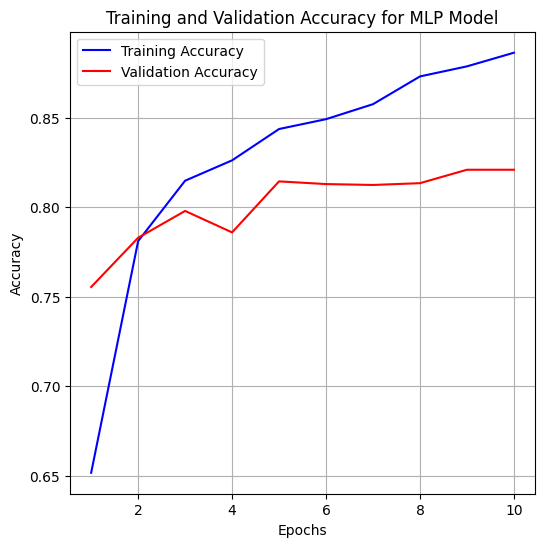

63/63 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step
Classification Report:
               precision    recall  f1-score   support

           0       0.83      0.90      0.86      1228
           1       0.81      0.70      0.75       772

    accuracy                           0.82      2000
   macro avg       0.82      0.80      0.81      2000
weighted avg       0.82      0.82      0.82      2000

F1 Score Overall: 0.7510


In [ ]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.utils import to_categorical
from sklearn.metrics import classification_report, f1_score


# Convert labels to categorical (for softmax output)
y_train_categorical = to_categorical(y_train)
y_test_categorical = to_categorical(y_test)

# Convert sparse matrix to dense format
X_train_dense = X_train.toarray()
X_test_dense = X_test.toarray()

# Define and compile MLP model
mlp_model = Sequential([
    Dense(128, activation="relu", input_shape=(X_train_dense.shape[1],)),
    Dropout(0.25),
    Dense(64, activation="relu"),
    Dropout(0.25),
    Dense(32, activation="relu"),
    Dropout(0.5),
    Dense(2, activation="softmax")
])

mlp_model.compile(optimizer=Adam(learning_rate=0.001),
                  loss="categorical_crossentropy",
                  metrics=["accuracy"])

# Train the model
history = mlp_model.fit(X_train_dense, y_train_categorical,
                        epochs=10, batch_size=64,
                        validation_data=(X_test_dense, y_test_categorical),
                        verbose=1)

from sklearn.metrics import classification_report
y_pred_mlp = mlp_model.predict(X_test_dense).argmax(axis=1)
print("MLP Model Performance:\n", classification_report(y_test, y_pred_mlp))


import matplotlib.pyplot as plt

# Extract training and validation accuracy
train_acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
epochs = range(1, len(train_acc) + 1)

# Plot the accuracy
plt.figure(figsize=(6, 6))
plt.plot(epochs, train_acc, 'b-', label='Training Accuracy')
plt.plot(epochs, val_acc, 'r-', label='Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title('Training and Validation Accuracy for MLP Model')
plt.legend(loc='best')
plt.grid(True)
plt.show()


y_pred_probs = mlp_model.predict(X_test)

# Convert to class predictions
y_pred = np.argmax(y_pred_probs, axis=1)
y_true = np.argmax(y_test_categorical, axis=1)

# Generate classification report
report = classification_report(y_true, y_pred)
print("Classification Report:\n", report)


f1_mlp = f1_score(y_true, y_pred, average='binary')
print(f"F1 Score Overall: {f1_mlp:.4f}")

**Random Forest**

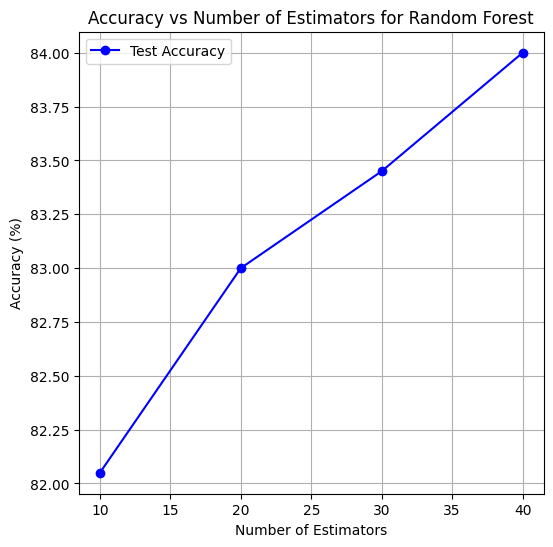

Accuracy: 84.00
Classification Report:
               precision    recall  f1-score   support

           0       0.85      0.89      0.87      1228
           1       0.81      0.76      0.79       772

    accuracy                           0.84      2000
   macro avg       0.83      0.82      0.83      2000
weighted avg       0.84      0.84      0.84      2000

F1 Score Overall: 0.8389


In [ ]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics import accuracy_score, classification_report
from sklearn.model_selection import train_test_split
import pandas as pd


# Text vectorization
vectorizer = TfidfVectorizer(max_features=5000)
X = vectorizer.fit_transform(df["clean_content"])
y = df["label"]

# Train-test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Train Random Forest model
rf_model = RandomForestClassifier(n_estimators=10, random_state=42)
rf_model.fit(X_train, y_train)


import matplotlib.pyplot as plt

# for different n_estimators
# as no epoch in rf so cant take that approach to get the graph
n_estimators = [10, 20, 30, 40]
accuracies = []

for n in n_estimators:
    rf_model = RandomForestClassifier(n_estimators=n, random_state=42)
    rf_model.fit(X_train, y_train)
    y_pred = rf_model.predict(X_test)
    accuracy = accuracy_score(y_test, y_pred)
    accuracies.append(accuracy * 100)

# Plot the accuracy
plt.figure(figsize=(6, 6))
plt.plot(n_estimators, accuracies, marker='o', linestyle='-', color='blue', label='Test Accuracy')
plt.xlabel('Number of Estimators')
plt.ylabel('Accuracy (%)')
plt.title('Accuracy vs Number of Estimators for Random Forest')
plt.legend(loc='best')
plt.grid(True)

# Add text annotation
# plt.text(n_estimators[-1] - 20, accuracies[-1] - 1, 'Graph for Random Forest', fontsize=12, color='purple')

plt.show()



# Predictions
y_pred = rf_model.predict(X_test)

# Evaluation
accuracy = accuracy_score(y_test, y_pred)
print(f"Accuracy: {accuracy*100:.2f}")
print("Classification Report:\n", classification_report(y_test, y_pred))

f1_rf = f1_score(y_true, y_pred, average='weighted')
print(f"F1 Score Overall: {f1_rf:.4f}")


**LSTM**

---



Epoch 1/10
125/125 ━━━━━━━━━━━━━━━━━━━━ 29s 192ms/step - accuracy: 0.6078 - loss: 0.6769 - val_accuracy: 0.6140 - val_loss: 0.6738
Epoch 2/10
125/125 ━━━━━━━━━━━━━━━━━━━━ 40s 185ms/step - accuracy: 0.6063 - loss: 0.6741 - val_accuracy: 0.6140 - val_loss: 0.6669
Epoch 3/10
125/125 ━━━━━━━━━━━━━━━━━━━━ 24s 193ms/step - accuracy: 0.6039 - loss: 0.6753 - val_accuracy: 0.6140 - val_loss: 0.6671
Epoch 4/10
125/125 ━━━━━━━━━━━━━━━━━━━━ 40s 186ms/step - accuracy: 0.6087 - loss: 0.6710 - val_accuracy: 0.6140 - val_loss: 0.6678
Epoch 5/10
125/125 ━━━━━━━━━━━━━━━━━━━━ 41s 187ms/step - accuracy: 0.6079 - loss: 0.6708 - val_accuracy: 0.6140 - val_loss: 0.6682
Epoch 6/10
125/125 ━━━━━━━━━━━━━━━━━━━━ 41s 186ms/step - accuracy: 0.6130 - loss: 0.6675 - val_accuracy: 0.6140 - val_loss: 0.6669
Epoch 7/10
125/125 ━━━━━━━━━━━━━━━━━━━━ 41s 185ms/step - accuracy: 0.6154 - loss: 0.6679 - val_accuracy: 0.6140 - val_loss: 0.6677
Epoch 8/10
125/125 ━━━━━━━━━━━━━━━━━━━━ 24s 194ms/step - accuracy: 0.6098 - loss: 0

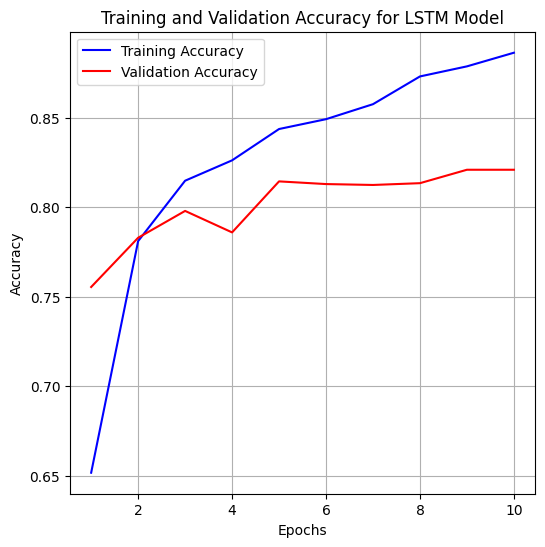

63/63 ━━━━━━━━━━━━━━━━━━━━ 3s 42ms/step - accuracy: 0.6123 - loss: 0.6692
Test Accuracy: 61.40%
63/63 ━━━━━━━━━━━━━━━━━━━━ 3s 33ms/step
Classification Report:
               precision    recall  f1-score   support

           0       0.61      1.00      0.76      1228
           1       0.00      0.00      0.00       772

    accuracy                           0.61      2000
   macro avg       0.31      0.50      0.38      2000
weighted avg       0.38      0.61      0.47      2000

F1 Score Overall: 0.4672


In [ ]:
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, LSTM, Dense, Dropout
from sklearn.model_selection import train_test_split

# Parameters
MAX_VOCAB_SIZE = 10000
MAX_SEQUENCE_LENGTH = 100
EMBEDDING_DIM = 100

# Tokenization
tokenizer = Tokenizer(num_words=MAX_VOCAB_SIZE, oov_token="<OOV>")
tokenizer.fit_on_texts(df["clean_content"])

# Convert text to sequences
sequences = tokenizer.texts_to_sequences(df["clean_content"])
padded_sequences = pad_sequences(sequences, maxlen=MAX_SEQUENCE_LENGTH, padding='post', truncating='post')

# Labels
labels = df["label"].values

# Train-test split
X_train, X_test, y_train, y_test = train_test_split(padded_sequences, labels, test_size=0.2, random_state=42)

# Define LSTM model
model = Sequential([
    Embedding(MAX_VOCAB_SIZE, EMBEDDING_DIM, input_length=MAX_SEQUENCE_LENGTH),
    LSTM(64, return_sequences=True),
    Dropout(0.5),
    LSTM(32),
    Dropout(0.5),
    Dense(1, activation='sigmoid')  # Binary classification
])

# Compile model
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

# Train model
model.fit(X_train, y_train, epochs=10, batch_size=64, validation_data=(X_test, y_test))


# Extract training and validation accuracy
train_acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
epochs = range(1, len(train_acc) + 1)

# Plot the accuracy
plt.figure(figsize=(6, 6))
plt.plot(epochs, train_acc, 'b-', label='Training Accuracy')
plt.plot(epochs, val_acc, 'r-', label='Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title('Training and Validation Accuracy for LSTM Model')
plt.legend(loc='best')
plt.grid(True)

# Add text annotation

plt.show()


# Evaluate the model on the test set

loss, accuracy = model.evaluate(X_test, y_test)
print(f"Test Accuracy: {accuracy * 100:.2f}%")

y_pred = (model.predict(X_test) > 0.5).astype("int32")

# Classification report
print("Classification Report:\n", classification_report(y_test, y_pred))

# Calculate weighted F1 score
f1_lstm = f1_score(y_test, y_pred, average='weighted')
print(f"F1 Score Overall: {f1_lstm:.4f}")

**GRU**

---



In [ ]:
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, GRU, Dense, Dropout
from sklearn.model_selection import train_test_split

# Parameters
MAX_VOCAB_SIZE = 10000
MAX_SEQUENCE_LENGTH = 100
EMBEDDING_DIM = 100

# Tokenization
tokenizer = Tokenizer(num_words=MAX_VOCAB_SIZE, oov_token="<OOV>")
tokenizer.fit_on_texts(df["clean_content"])

# Convert text to sequences
sequences = tokenizer.texts_to_sequences(df["clean_content"])
padded_sequences = pad_sequences(sequences, maxlen=MAX_SEQUENCE_LENGTH, padding='post', truncating='post')

# Labels
labels = df["label"].values

# Train-test split
X_train, X_test, y_train, y_test = train_test_split(padded_sequences, labels, test_size=0.2, random_state=42)

# Define GRU model
model = Sequential([
    Embedding(MAX_VOCAB_SIZE, EMBEDDING_DIM, input_length=MAX_SEQUENCE_LENGTH),
    #Embedding(input_dim=5000, output_dim=128, input_length=100),
    GRU(128, return_sequences=True),
    Dropout(0.5),
    GRU(64),
    Dropout(0.5),
    Dense(1, activation='sigmoid')  # Binary classification
])

# Compile model
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

# Train model
model.fit(X_train, y_train, epochs=10, batch_size=64, validation_data=(X_test, y_test))
# Evaluate the model on the test set
loss, accuracy = model.evaluate(X_test, y_test)
print(f"Test Accuracy: {accuracy * 100:.2f}%")


y_pred_probs = model.predict(X_test)
y_pred = (y_pred_probs > 0.5).astype("int32")

# Classification report
print("Classification Report:\n", classification_report(y_test, y_pred))

# Calculate weighted F1 score
f1_gru = f1_score(y_test, y_pred, average='weighted')
print(f"Weighted F1 Score: {f1_gru:.4f}")

Epoch 1/10
125/125 ━━━━━━━━━━━━━━━━━━━━ 56s 418ms/step - accuracy: 0.6134 - loss: 0.6702 - val_accuracy: 0.6165 - val_loss: 0.6667
Epoch 2/10
125/125 ━━━━━━━━━━━━━━━━━━━━ 50s 397ms/step - accuracy: 0.6137 - loss: 0.6709 - val_accuracy: 0.6165 - val_loss: 0.6658
Epoch 3/10
125/125 ━━━━━━━━━━━━━━━━━━━━ 55s 439ms/step - accuracy: 0.6060 - loss: 0.6728 - val_accuracy: 0.6165 - val_loss: 0.6664
Epoch 4/10
125/125 ━━━━━━━━━━━━━━━━━━━━ 52s 417ms/step - accuracy: 0.6202 - loss: 0.6658 - val_accuracy: 0.6165 - val_loss: 0.6662
Epoch 5/10
125/125 ━━━━━━━━━━━━━━━━━━━━ 78s 388ms/step - accuracy: 0.6068 - loss: 0.6739 - val_accuracy: 0.6165 - val_loss: 0.6659
Epoch 6/10
125/125 ━━━━━━━━━━━━━━━━━━━━ 85s 417ms/step - accuracy: 0.6093 - loss: 0.6709 - val_accuracy: 0.6165 - val_loss: 0.6661
Epoch 7/10
125/125 ━━━━━━━━━━━━━━━━━━━━ 81s 413ms/step - accuracy: 0.6031 - loss: 0.6725 - val_accuracy: 0.6165 - val_loss: 0.6658
Epoch 8/10
125/125 ━━━━━━━━━━━━━━━━━━━━ 49s 396ms/step - accuracy: 0.6109 - loss: 0

**CONVOLUTION**

---



Epoch 1/10
125/125 ━━━━━━━━━━━━━━━━━━━━ 12s 79ms/step - accuracy: 0.6158 - loss: 0.6661 - val_accuracy: 0.7140 - val_loss: 0.5556
Epoch 2/10
125/125 ━━━━━━━━━━━━━━━━━━━━ 9s 68ms/step - accuracy: 0.7581 - loss: 0.4983 - val_accuracy: 0.7690 - val_loss: 0.4802
Epoch 3/10
125/125 ━━━━━━━━━━━━━━━━━━━━ 10s 78ms/step - accuracy: 0.8799 - loss: 0.3132 - val_accuracy: 0.7985 - val_loss: 0.4818
Epoch 4/10
125/125 ━━━━━━━━━━━━━━━━━━━━ 10s 79ms/step - accuracy: 0.9458 - loss: 0.1750 - val_accuracy: 0.7920 - val_loss: 0.5509
Epoch 5/10
125/125 ━━━━━━━━━━━━━━━━━━━━ 10s 79ms/step - accuracy: 0.9680 - loss: 0.1063 - val_accuracy: 0.8135 - val_loss: 0.6003
Epoch 6/10
125/125 ━━━━━━━━━━━━━━━━━━━━ 9s 68ms/step - accuracy: 0.9800 - loss: 0.0619 - val_accuracy: 0.8025 - val_loss: 0.6941
Epoch 7/10
125/125 ━━━━━━━━━━━━━━━━━━━━ 11s 73ms/step - accuracy: 0.9885 - loss: 0.0405 - val_accuracy: 0.8205 - val_loss: 0.7463
Epoch 8/10
125/125 ━━━━━━━━━━━━━━━━━━━━ 10s 78ms/step - accuracy: 0.9888 - loss: 0.0400 - va

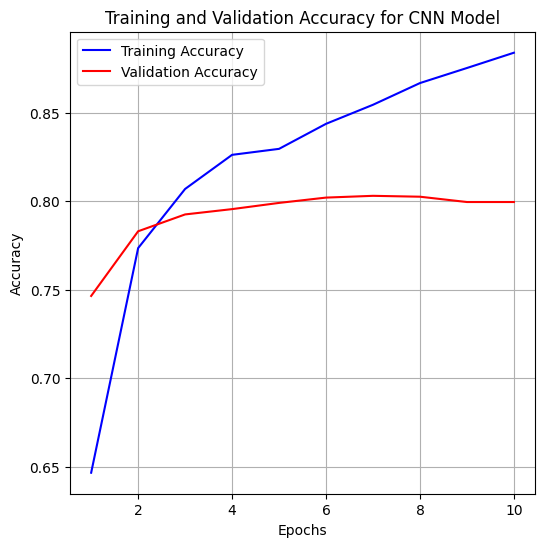

63/63 ━━━━━━━━━━━━━━━━━━━━ 1s 18ms/step
Classification Report:
               precision    recall  f1-score   support

           0       0.87      0.81      0.84      1233
           1       0.72      0.80      0.76       767

    accuracy                           0.81      2000
   macro avg       0.79      0.80      0.80      2000
weighted avg       0.81      0.81      0.81      2000

Weighted F1 Score: 0.8070


In [ ]:
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, Conv1D, GlobalMaxPooling1D, Dense, Dropout, Input, SpatialDropout1D
from sklearn.model_selection import train_test_split

# Parameters
MAX_VOCAB_SIZE = 10000
MAX_SEQUENCE_LENGTH = 100
EMBEDDING_DIM = 100

# Tokenization
tokenizer = Tokenizer(num_words=MAX_VOCAB_SIZE, oov_token="<OOV>")
tokenizer.fit_on_texts(df["clean_content"])

# Convert text to sequences
sequences = tokenizer.texts_to_sequences(df["clean_content"])
padded_sequences = pad_sequences(sequences, maxlen=MAX_SEQUENCE_LENGTH, padding='post', truncating='post')

# Labels
labels = df["label"].values

# Train-test split
X_train, X_test, y_train, y_test = train_test_split(padded_sequences, labels, test_size=0.2, random_state=42)

# Build Convolutional model
model = Sequential([
    Input(shape=(100,)),
    Embedding(MAX_VOCAB_SIZE, EMBEDDING_DIM, input_length=MAX_SEQUENCE_LENGTH),
    SpatialDropout1D(0.2),
    Conv1D(128, 5, activation='relu'),
    GlobalMaxPooling1D(),
    Dense(64, activation='relu'),
    Dropout(0.5),
    Dense(1, activation='sigmoid')
])

# Compile model
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

# Train model
model.fit(X_train, y_train, epochs=10, batch_size=64, validation_data=(X_test, y_test))
# Evaluate the model on the test set
loss, accuracy = model.evaluate(X_test, y_test)
print(f"Test Accuracy: {accuracy * 100:.2f}%")



import matplotlib.pyplot as plt

# Extract training and validation accuracy
train_acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
epochs = range(1, len(train_acc) + 1)

# Plot the accuracy
plt.figure(figsize=(6, 6))
plt.plot(epochs, train_acc, 'b-', label='Training Accuracy')
plt.plot(epochs, val_acc, 'r-', label='Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title('Training and Validation Accuracy for CNN Model')
plt.legend(loc='best')
plt.grid(True)
plt.show()





y_pred_probs = model.predict(X_test)
y_pred = (y_pred_probs > 0.5).astype("int32")

# Classification Report
print("Classification Report:\n", classification_report(y_test, y_pred))

# Calculate Weighted F1 Score
f1_conv = f1_score(y_test, y_pred, average='weighted')
print(f"Weighted F1 Score: {f1_conv:.4f}")







**BIDIRECTIONAL+LSTM**

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


Epoch 1/10
100/100 ━━━━━━━━━━━━━━━━━━━━ 45s 380ms/step - accuracy: 0.6174 - loss: 0.6622 - val_accuracy: 0.7219 - val_loss: 0.5652
Epoch 2/10
100/100 ━━━━━━━━━━━━━━━━━━━━ 39s 360ms/step - accuracy: 0.7961 - loss: 0.4727 - val_accuracy: 0.7269 - val_loss: 0.5521
Epoch 3/10
100/100 ━━━━━━━━━━━━━━━━━━━━ 45s 398ms/step - accuracy: 0.8687 - loss: 0.3331 - val_accuracy: 0.7506 - val_loss: 0.5482
Epoch 4/10
100/100 ━━━━━━━━━━━━━━━━━━━━ 39s 375ms/step - accuracy: 0.9169 - loss: 0.2292 - val_accuracy: 0.7594 - val_loss: 0.6845
Epoch 5/10
100/100 ━━━━━━━━━━━━━━━━━━━━ 41s 379ms/step - accuracy: 0.9466 - loss: 0.1678 - val_accuracy: 0.7356 - val_loss: 0.7994
Epoch 6/10
100/100 ━━━━━━━━━━━━━━━━━━━━ 37s 375ms/step - accuracy: 0.9557 - loss: 0.1349 - val_accuracy: 0.7525 - val_loss: 0.9148
Epoch 7/10
100/100 ━━━━━━━━━━━━━━━━━━━━ 41s 376ms/step - accuracy: 0.9693 - loss: 0.0927 - val_accuracy: 0.7362 - val_loss: 0.9780
Epoch 8/10
100/100 ━━━━━━━━━━━━━━━━━━━━ 41s 375ms/step - accuracy: 0.9693 - loss: 0

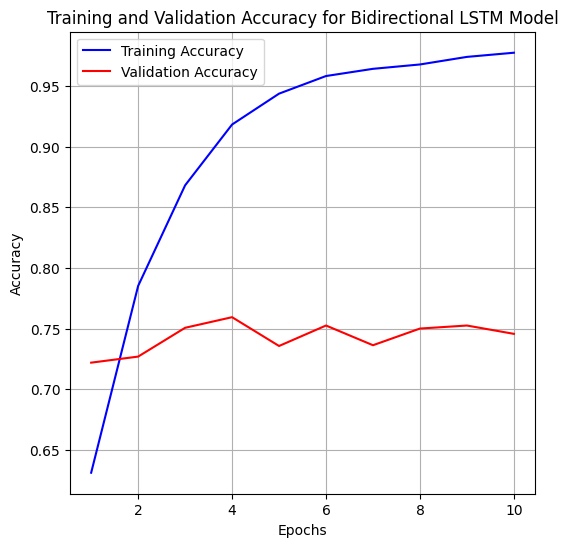

63/63 ━━━━━━━━━━━━━━━━━━━━ 6s 78ms/step
Classification Report:
               precision    recall  f1-score   support

           0       0.84      0.78      0.81      1233
           1       0.68      0.76      0.72       767

    accuracy                           0.77      2000
   macro avg       0.76      0.77      0.76      2000
weighted avg       0.78      0.77      0.77      2000

Weighted F1 Score: 0.7710


In [ ]:
import tensorflow as tf
import re
import nltk
import spacy
import numpy as np
import pandas as pd
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, Bidirectional, LSTM, Dense, Dropout
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from sklearn.model_selection import train_test_split
from nltk.corpus import stopwords
from tqdm import tqdm

# Load Spacy model and stopwords
nltk.download('stopwords')
nlp = spacy.load("en_core_web_sm")
stop_words = set(stopwords.words('english'))

# Function to preprocess text
def preprocess_data(content):
    content = content.lower()
    content = re.sub(r"http\S+|www\S+|https\S+", '', content)  # Remove links
    content = re.sub(r'@\w+', '', content)  # Remove mentions
    content = re.sub(r'[^\w\s#]', '', content)  # Remove special characters
    tokens = [token.lemma_ for token in nlp(content) if token.text not in stop_words and len(token.text) > 1]
    return " ".join(tokens)

# Apply preprocessing
df['clean_content'] = df['content'].apply(preprocess_data)

# Tokenization and padding
max_words = 10000
max_len = 100
embedding_dim = 125
tokenizer = Tokenizer(num_words=max_words, oov_token="<OOV>")
tokenizer.fit_on_texts(df['clean_content'])

X = tokenizer.texts_to_sequences(df['clean_content'])
X = pad_sequences(X, maxlen=max_len, padding='post', truncating='post')

y = df['label'].values

# Splitting dataset
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Define Bidirectional LSTM model
model = Sequential([
    Embedding(input_dim=max_words, output_dim=embedding_dim, input_length=max_len),
    Bidirectional(LSTM(64, return_sequences=True)),
    Dropout(0.5),
    Bidirectional(LSTM(32)),
    Dense(32, activation='relu'),
    Dropout(0.5),
    Dense(1, activation='sigmoid')
])

# Compile model
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

# Train model
epochs = 10
batch_size = 64
history = model.fit(X_train, y_train, epochs=epochs, batch_size=batch_size, validation_split=0.2)

# Evaluate model
loss, accuracy = model.evaluate(X_test, y_test)
print(f"Test Accuracy: {accuracy * 100:.2f}%")



import matplotlib.pyplot as plt

# Extract training and validation accuracy
train_acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
epochs = range(1, len(train_acc) + 1)

# Plot the accuracy
plt.figure(figsize=(6, 6))
plt.plot(epochs, train_acc, 'b-', label='Training Accuracy')
plt.plot(epochs, val_acc, 'r-', label='Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title('Training and Validation Accuracy for Bidirectional LSTM Model')
plt.legend(loc='best')
plt.grid(True)

plt.show()





y_pred_probs = model.predict(X_test)
y_pred = (y_pred_probs > 0.5).astype("int32")

# Classification Report
print("Classification Report:\n", classification_report(y_test, y_pred))

# Calculate Weighted F1 Score
f1_bi_lstm = f1_score(y_test, y_pred, average='weighted')
print(f"Weighted F1 Score: {f1_bi_lstm:.4f}")







**Bidirection+GRU**

Epoch 1/10
125/125 ━━━━━━━━━━━━━━━━━━━━ 33s 205ms/step - accuracy: 0.6210 - loss: 0.6524 - val_accuracy: 0.7125 - val_loss: 0.5407
Epoch 2/10
125/125 ━━━━━━━━━━━━━━━━━━━━ 26s 208ms/step - accuracy: 0.8141 - loss: 0.4217 - val_accuracy: 0.7815 - val_loss: 0.4922
Epoch 3/10
125/125 ━━━━━━━━━━━━━━━━━━━━ 25s 199ms/step - accuracy: 0.9185 - loss: 0.2170 - val_accuracy: 0.8065 - val_loss: 0.5049
Epoch 4/10
125/125 ━━━━━━━━━━━━━━━━━━━━ 40s 193ms/step - accuracy: 0.9554 - loss: 0.1322 - val_accuracy: 0.7850 - val_loss: 0.6469
Epoch 5/10
125/125 ━━━━━━━━━━━━━━━━━━━━ 43s 207ms/step - accuracy: 0.9738 - loss: 0.0877 - val_accuracy: 0.7970 - val_loss: 0.7038
Epoch 6/10
125/125 ━━━━━━━━━━━━━━━━━━━━ 41s 207ms/step - accuracy: 0.9774 - loss: 0.0717 - val_accuracy: 0.7910 - val_loss: 0.9384
Epoch 7/10
125/125 ━━━━━━━━━━━━━━━━━━━━ 25s 200ms/step - accuracy: 0.9835 - loss: 0.0532 - val_accuracy: 0.7755 - val_loss: 1.0155
Epoch 8/10
125/125 ━━━━━━━━━━━━━━━━━━━━ 40s 189ms/step - accuracy: 0.9869 - loss: 0

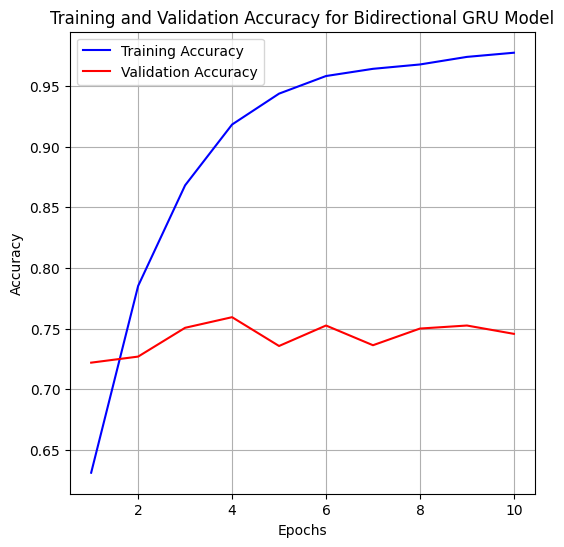

63/63 ━━━━━━━━━━━━━━━━━━━━ 2s 34ms/step
Classification Report:
               precision    recall  f1-score   support

           0       0.86      0.77      0.81      1233
           1       0.68      0.80      0.74       767

    accuracy                           0.78      2000
   macro avg       0.77      0.78      0.77      2000
weighted avg       0.79      0.78      0.78      2000

Weighted F1 Score: 0.7834


In [ ]:
import tensorflow as tf
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, Bidirectional, GRU, Dense, Dropout
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score

# Assuming df['clean_content'] is already preprocessed
# Tokenization
tokenizer = Tokenizer()
tokenizer.fit_on_texts(df['clean_content'])
X = tokenizer.texts_to_sequences(df['clean_content'])
X = pad_sequences(X, maxlen=50)

# Labels
y = df['label'].values

# Train-test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Model Architecture
model = Sequential([
    Embedding(input_dim=len(tokenizer.word_index) + 1, output_dim=128, input_length=50),
    Bidirectional(GRU(64, return_sequences=True)),
    Bidirectional(GRU(32)),
    Dense(32, activation='relu'),
    Dropout(0.5),
    Dense(1, activation='sigmoid')
])

# Compile Model
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

# Train Model
model.fit(X_train, y_train, validation_data=(X_test, y_test), epochs=10, batch_size=64)

# Predict and Calculate Accuracy
y_pred = (model.predict(X_test) > 0.5).astype("int32")
accuracy = accuracy_score(y_test, y_pred)
print(f"Test Accuracy: {accuracy:.4f}")




import matplotlib.pyplot as plt

# Extract training and validation accuracy
train_acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
epochs = range(1, len(train_acc) + 1)

# Plotting
plt.figure(figsize=(6, 6))
plt.plot(epochs, train_acc, 'b-', label='Training Accuracy')
plt.plot(epochs, val_acc, 'r-', label='Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title('Training and Validation Accuracy for Bidirectional GRU Model')
plt.legend(loc='best')
plt.grid(True)

plt.show()




y_pred_probs = model.predict(X_test)
y_pred = (y_pred_probs > 0.5).astype("int32")

# Classification Report
print("Classification Report:\n", classification_report(y_test, y_pred))

# Calculate Weighted F1 Score
f1_bi_gru = f1_score(y_test, y_pred, average='weighted')
print(f"Weighted F1 Score: {f1_bi_gru:.4f}")



# Improvement to Increase the Accuracy

**Introducing the Word Augmentation and Bag of Words**

In [ ]:
# Initialize the WordNet Augmenter
augmenter = WordNetAugmenter()

# Perform data augmentation by generating one augmented sentence per input
df_augmented = pd.DataFrame({
    'clean_content': df['clean_content'].apply(lambda x: augmenter.augment(x)[0] if len(augmenter.augment(x)) > 0 else x),
    'label': df['label']
})

# Combine original and augmented data
df_combined = pd.concat([df, df_augmented])

# Shuffle the dataset to ensure variety
df_combined = df_combined.sample(frac=1, random_state=42).reset_index(drop=True)

# Split dataset
X_train_texts, X_test_texts, y_train, y_test = train_test_split(df_combined['clean_content'], df_combined['label'], test_size=0.2, random_state=42)

# TF-IDF (Unigram) Feature Extraction
tfidf_vectorizer = TfidfVectorizer(ngram_range=(1, 1))
X_train_tfidf = tfidf_vectorizer.fit_transform(X_train_texts)
X_test_tfidf = tfidf_vectorizer.transform(X_test_texts)

# BoW (Count Vectorizer)
bow_vectorizer = CountVectorizer(ngram_range=(1, 1))
X_train_bow = bow_vectorizer.fit_transform(X_train_texts)
X_test_bow = bow_vectorizer.transform(X_test_texts)

# Combine both feature sets (TF-IDF + BoW)
X_train_combined = np.hstack((X_train_tfidf.toarray(), X_train_bow.toarray()))
X_test_combined = np.hstack((X_test_tfidf.toarray(), X_test_bow.toarray()))

# Convert labels to categorical
y_train_categorical = to_categorical(y_train)
y_test_categorical = to_categorical(y_test)

[nltk_data] Downloading package omw-1.4 to /root/nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!


**MLP**

Epoch 1/5
250/250 ━━━━━━━━━━━━━━━━━━━━ 11s 39ms/step - accuracy: 0.6556 - loss: 0.6107 - val_accuracy: 0.8367 - val_loss: 0.3710
Epoch 2/5
250/250 ━━━━━━━━━━━━━━━━━━━━ 8s 34ms/step - accuracy: 0.9161 - loss: 0.2313 - val_accuracy: 0.8990 - val_loss: 0.2610
Epoch 3/5
250/250 ━━━━━━━━━━━━━━━━━━━━ 10s 34ms/step - accuracy: 0.9676 - loss: 0.0958 - val_accuracy: 0.9075 - val_loss: 0.2541
Epoch 4/5
250/250 ━━━━━━━━━━━━━━━━━━━━ 10s 32ms/step - accuracy: 0.9818 - loss: 0.0545 - val_accuracy: 0.9195 - val_loss: 0.2539
Epoch 5/5
250/250 ━━━━━━━━━━━━━━━━━━━━ 11s 37ms/step - accuracy: 0.9893 - loss: 0.0374 - val_accuracy: 0.9168 - val_loss: 0.2815
125/125 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - accuracy: 0.9141 - loss: 0.3123
Test Accuracy: 91.68%


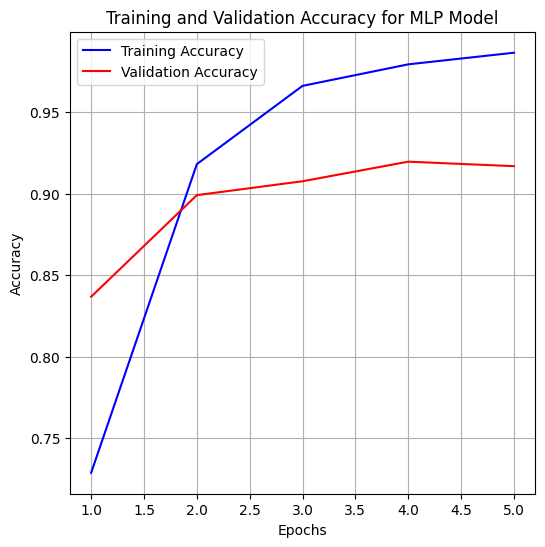

125/125 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step
Classification Report:
               precision    recall  f1-score   support

           0       0.94      0.92      0.93      2448
           1       0.88      0.90      0.89      1552

    accuracy                           0.92      4000
   macro avg       0.91      0.91      0.91      4000
weighted avg       0.92      0.92      0.92      4000

F1 Score Overall: 0.9169


In [ ]:
mlp_model = Sequential([
    Dense(64, activation="relu", input_shape=(X_train_combined.shape[1],)),
    Dropout(0.3),
    Dense(32, activation="relu"),
    Dropout(0.3),
    Dense(2, activation="softmax")
])

mlp_model.compile(optimizer=Adam(learning_rate=0.001),
                  loss="categorical_crossentropy",
                  metrics=["accuracy"])

# Train the model
history = mlp_model.fit(X_train_combined, y_train_categorical,
                        epochs=5, batch_size=64,
                        validation_data=(X_test_combined, y_test_categorical),
                        verbose=1)



test_loss, test_accuracy = mlp_model.evaluate(X_test_combined, y_test_categorical, verbose=1)
print(f"Test Accuracy: {test_accuracy * 100:.2f}%")


train_acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
epochs = range(1, len(train_acc) + 1)


plt.figure(figsize=(6, 6))
plt.plot(epochs, train_acc, 'b-', label='Training Accuracy')
plt.plot(epochs, val_acc, 'r-', label='Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title('Training and Validation Accuracy for MLP Model')
plt.legend(loc='best')
plt.grid(True)
plt.show()



y_pred_probs = mlp_model.predict(X_test_combined)

# Convert to class predictions
y_pred = np.argmax(y_pred_probs, axis=1)
y_true = np.argmax(y_test_categorical, axis=1)

# Generate classification report
report = classification_report(y_true, y_pred)
print("Classification Report:\n", report)


f1_mlp_aug = f1_score(y_true, y_pred, average='weighted')
print(f"F1 Score Overall: {f1_mlp_aug:.4f}")

from google.colab import drive
drive.mount('/content/drive')
model.save('/content/drive/MyDrive/model.h5')

**Random Forest**

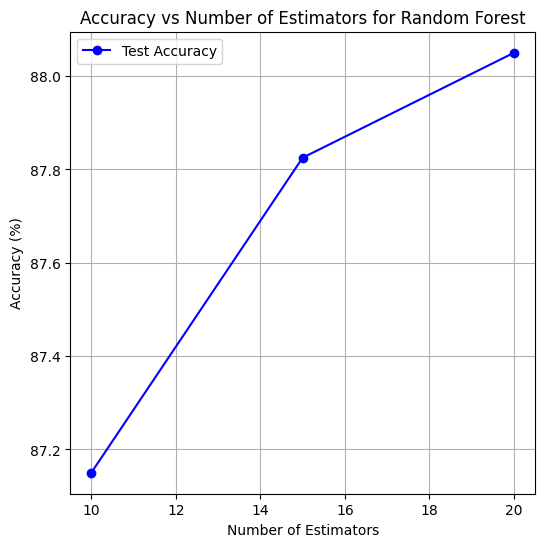

Classification Report:
              precision    recall  f1-score   support

           0       0.89      0.92      0.90      2448
           1       0.87      0.82      0.84      1552

    accuracy                           0.88      4000
   macro avg       0.88      0.87      0.87      4000
weighted avg       0.88      0.88      0.88      4000

F1 Score: 0.8798


In [ ]:
from sklearn.ensemble import RandomForestClassifier
rf_model = RandomForestClassifier(n_estimators=10)
rf_model.fit(X_train_combined, y_train)

y_pred = rf_model.predict(X_test_combined)


# Evaluation Graph
# for different n_estimators
# as no epoch in rf so cant take that approach to get the graph
n_estimators = [10,15, 20]
accuracies = []
from sklearn.metrics import accuracy_score

for n in n_estimators:
    rf_model = RandomForestClassifier(n_estimators=n, random_state=42)
    rf_model.fit(X_train_combined, y_train)
    y_pred = rf_model.predict(X_test_combined)
    accuracy = accuracy_score(y_test, y_pred)
    accuracies.append(accuracy * 100)

# Plot the accuracy
plt.figure(figsize=(6, 6))
plt.plot(n_estimators, accuracies, marker='o', linestyle='-', color='blue', label='Test Accuracy')
plt.xlabel('Number of Estimators')
plt.ylabel('Accuracy (%)')
plt.title('Accuracy vs Number of Estimators for Random Forest')
plt.legend(loc='best')
plt.grid(True)
plt.show()

print("Classification Report:")
print(classification_report(y_test, y_pred))

# Calculate F1 Score
f1_rf_aug = f1_score(y_test, y_pred, average='weighted')
print(f"F1 Score: {f1_rf_aug:.4f}")

# F1-Score Compare

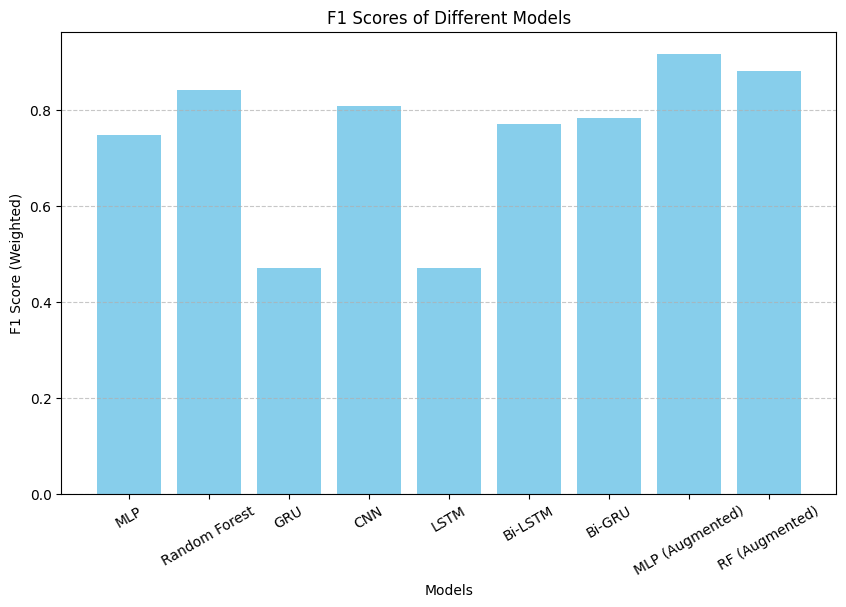

In [ ]:
f1_scores = {
    "MLP": f1_mlp,
    "Random Forest": f1_rf,
    "GRU": f1_gru,
    "CNN": f1_conv,
    "LSTM": f1_lstm,
    "Bi-LSTM": f1_bi_lstm,
    "Bi-GRU": f1_bi_gru,
    "MLP (Augmented)": f1_mlp_aug,
    "RF (Augmented)": f1_rf_aug,
}

# Plotting the histogram
plt.figure(figsize=(10, 6))
plt.bar(f1_scores.keys(), f1_scores.values(), color='skyblue')
plt.xlabel('Models')
plt.ylabel('F1 Score (Weighted)')
plt.title('F1 Scores of Different Models')
plt.xticks(rotation=30)
plt.grid(axis='y', linestyle='--', alpha=0.7)

# Display the plot
plt.show()